<h1 align="center">Using Maching Learning for Credit Card Fraud Detection - A Springboard Capstone Project</h1>

### Installing Relevant Packages & Libraries

In [1]:
!conda install -c conda-forge shap --yes

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: \ 


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [2]:
!pip install smdebug --upgrade

In [3]:
!pip install imblearn

In [4]:
!pip install scikit-learn

In [5]:
!conda update packaging

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: - 


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [6]:
!pip install --upgrade sagemaker

In [7]:
!pip install seaborn

In [8]:
!pip install joblib

In [9]:
import re
import s3fs
import shap
import time
import boto3
import io
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.inputs import TrainingInput
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImPipline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import set_config
import time
from datetime import timedelta
import joblib

import warnings
warnings.filterwarnings('ignore')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/24/25 14:18:54] INFO     Found credentials from IAM Role:                                   ]8;id=237314;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=487268;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [10]:
# Defining s3 bucket
default_bucket = "fd-sagemaker-bucket"

In [11]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

[03/24/25 14:18:55] INFO     Found credentials from IAM Role:                                   ]8;id=358765;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=120490;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/24/25 14:18:56] INFO     Found credentials from IAM Role:                                   ]8;id=862454;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=920406;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

### Load Data

In [12]:
trans_data = pd.read_csv(f"s3://{default_bucket}/card_transdata.csv")

                    INFO     Found credentials from IAM Role:                                   ]8;id=188305;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=116140;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

##### Description 

This dataset captures transaction patterns and behaviors that could indicate potential fraud in card transactions. The data is composed of several features designed to reflect the transactional context such as geographical location, transaction medium, and spending behavior relative to the user's history.

##### Origin
Credit_Card_Fraud_: https://www.openml.org/search?type=data&status=active&id=45955&sort=runs

card_transdata.csv: https://github.com/Baz177/capstone_project/blob/main/card_transdata.csv

### Removing Outliers

In [13]:
def rem_outliers(df, col):
    """function to remove outliers"""

    #percentiles
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    #IQR
    IQR = Q3 - Q1

    #Define Lower and Upper bounds
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    df[col] = df[col].clip(lower = lower_bound, upper = upper_bound)

    return df

In [14]:
df_2 = rem_outliers(trans_data, 'distace_from_home')
df_1 = rem_outliers(trans_data, 'distance_from_last_transaction')
df = rem_outliers(trans_data, 'ratio_to_median_purchase_price')

### Train Model 

In [15]:
def train_model(df, batch_size):

    # Balancing and Splitting data
    X = df.drop(columns = 'fraud', axis = 1)
    y = df['fraud']
    smote = SMOTE(sampling_strategy = 'auto', random_state = 10, k_neighbors = 4)
    X_oversampled, y_oversampled = smote.fit_resample(X, y)
    
    # Splitting data between train and tests sets 
    X_train, X_test, y_train, y_test = train_test_split(X_oversampled.values, y_oversampled.values, test_size=0.2, random_state=10, stratify = y_oversampled)
    
    # Streamlining data for faster execution. 
    global pipe
    pipe = Pipeline([('scalar', StandardScaler()), 
                    ('pca', PCA(n_components = .90, random_state = 10)), # Apply PCA to only carry important featurers
                    ('random_forest_classifier', RandomForestClassifier(max_depth = 20, 
                                                                        min_samples_split = 12, 
                                                                        n_estimators = 150, 
                                                                        n_jobs = -1))]) # Applying Hypertuned Classifier

    num_samples = X_train.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))  # Calculate number of batches

    # Training batches 
    print('Model Training has begun ...Please wait')
    print('. . . . ....') 
    accuracy_scores = []
    training_start_time = time.time()
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, num_samples)  # Handle last batch
        batch_X = X_train[start:end]
        batch_y = y_train[start:end]
        pipe.fit(batch_X, batch_y)

        # Recording accuracy
        accuracy = accuracy_score(batch_y, pipe.predict(batch_X))
        accuracy_scores.append(accuracy)
        
    # Time Record
    elapsed_time = time.time() - training_start_time
    formatted_time = str(round(timedelta(seconds=elapsed_time).total_seconds()/60,2))
    print(f"Training {num_batches} batches took: {formatted_time} mins ")
        
    # Checking accuracy of Model
    sns.histplot(x = accuracy_scores, bins = 25, kde = True, legend = False, color="skyblue")
    plt.title('Accuracy distribution over batches') 
    plt.xlabel('Acuracy')
    plt.show()
    cm = confusion_matrix(y_test, pipe.predict(X_test))
    
    sns.heatmap(cm, annot = True, fmt=  'g', cmap = 'Blues')
    plt.show()
    return classification_report(y_test, pipe.predict(X_test))

Model Training has begun ...Please wait
. . . . ....
Training 1461 batches took: 13.86 mins 


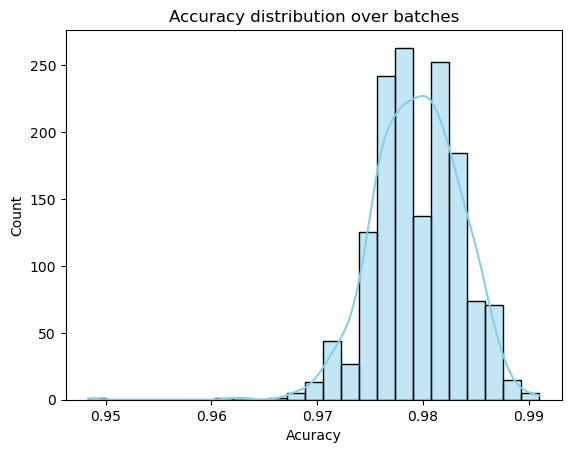

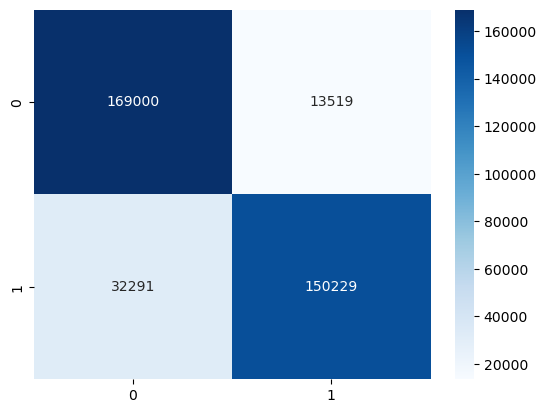

              precision    recall  f1-score   support

           0       0.84      0.93      0.88    182519
           1       0.92      0.82      0.87    182520

    accuracy                           0.87    365039
   macro avg       0.88      0.87      0.87    365039
weighted avg       0.88      0.87      0.87    365039



In [16]:
print(train_model(trans_data, 1000))

In [17]:
joblib.dump(pipe, 'fraud_model.pkl')
print("Model trained and saved as 'fraud_model.pkl'")

Model trained and saved as 'fraud_model.pkl'


In [18]:
fs = s3fs.S3FileSystem()
fs.put("fraud_model.pkl", f"s3://{default_bucket}/trained-model/fraud_model.pkl")